In [1]:
import os, sys, time, copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import multiprocessing
from functools import partial
from tqdm import tqdm

import collections
from typing import List

import myokit
sys.path.append('../')
sys.path.append('../Protocols')
sys.path.append('../Models')
sys.path.append('../Lib')
import protocol_lib
import mod_trace

import simulator_myokit
import simulator_scipy
import vc_protocols

In [2]:
def find_closest_index(array, t):
    """Given an array, return the index with the value closest to t."""
    return (np.abs(np.array(array) - t)).argmin()

def get_currents_with_constant_dt(param, x):
        
    window = param['window']
    step_size = param['step_size']
        
    times = x[0]
    i_ion = x[1]
              
    i_ion_window = []
    t = 0
    while t <= times[-1] - window:
        start_index = find_closest_index(times, t)
        end_index = find_closest_index(times, t + window)            
        I_window = i_ion[start_index: end_index + 1]                                    
        i_ion_window.append(sum(I_window)/len(I_window))            
        t += step_size
            
    return i_ion_window

In [3]:
# V = model.voltage(times)
g = 0.1524 * 1e3 # [pA/V]
p1 = 2.26e-4 * 1e3 # [1/s]
p2 = 0.0699 * 1e3  # [1/V]
p3 = 3.45e-5 * 1e3 # [1/s]
p4 = 0.05462 * 1e3 # [1/V]
p5 = 0.0873 * 1e3  # [1/s]
p6 = 8.91e-3 * 1e3 # [1/V]
p7 = 5.15e-3 * 1e3 # [1/s]
p8 = 0.03158 * 1e3 # [1/V]

dt = 0.0002
t_eval = np.arange(77000)*dt  # times = np.linspace(0, 15.4, 77000)
t_span = (0, t_eval.max())
t_span

(0, 15.3998)

The protocol is 15.4 s


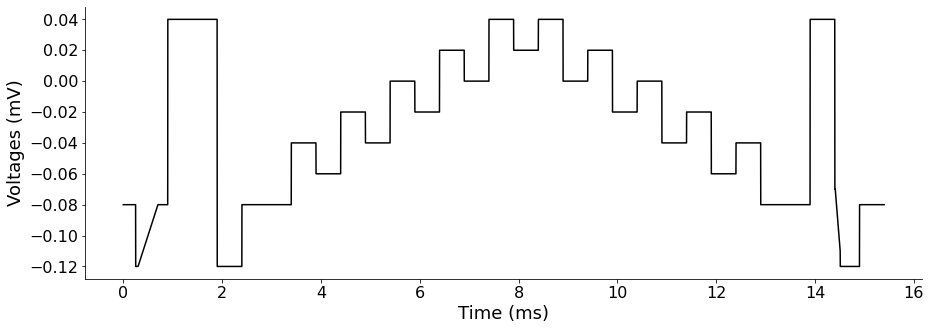

In [4]:
'''
leak_staircase
'''
# VC_protocol = vc_protocols.hERG_CiPA()
# VC_protocol = vc_protocols.cav12_CiPA()
# VC_protocol = vc_protocols.lateNav15_CiPA()

# VC_protocol = vc_protocols_for_myokit.leak_staircase()
VC_protocol = vc_protocols.leak_staircase()

print(f'The protocol is {VC_protocol.get_voltage_change_endpoints()[-1]} s')
VC_protocol.plot_voltage_clamp_protocol(t_eval)

In [5]:
gen_params = {
    'end_time': VC_protocol.get_voltage_change_endpoints()[-1],   
    't_eval' : t_eval, 
    'log_li' : ['ikr.IKr', 'ikr.open', 'ikr.active'],
    'save_log_li' : ['ikr.IKr'],
    'nData' : 5,                         
    # 'dataset_dir' : '../../Dataset/ohara2017_LeemV1',
    'dataset_dir' : f'../../Dataset/herg25oc1_real_data',
    'data_file_name' : 'IKr',
    'window' : 10,
    'step_size' : 5,
}  
# gen_params['dataset_dir'] = gen_params['dataset_dir'] + f"_w{gen_params['window']}_s{gen_params['step_size']}"
print( gen_params['dataset_dir'] )

sys.path.append(gen_params['dataset_dir'])
from getdata import get_dataset, get_times

../../Dataset/herg25oc1_real_data


### Get experimental dataset

In [6]:
# for i in range(5):
# xs, ys = get_dataset(file_numbers=range(1, 3), multi=True, use_torch=True)

# xs, ys = get_dataset(file_numbers=range(1, 31), window=10, step_size=5, multi=False, use_torch=False, get_raw=False)

cell_to_remove=['A04', 'A15', 'E05', 'E22', 'G10', 'G22', 'H08', 'I10', 'I12', 'I16', 'L08', 'P15', 'P18' ] # M24
cell_to_remove=[]

xs, ys, cells = get_dataset(cell_to_remove=cell_to_remove, scale=1, multi=True, torch_tensor=False)  # <-- fast
times = get_times(scale=1)

The number of full cells : 211
The number of removed Cells : 0
The number of cells : 211


In [7]:
print(xs.shape, ys.shape)

(211, 77000) (211, 9)


### Simulation setting

In [8]:
start_time = time.time()

# hERG model settings
temperature = 25.0
temperature += 273.15  # in K
fit_seed = '542811797'
withfcap = False

model, p, s = myokit.load("../mmt-model-files/kylie-2017-IKr.mmt")    
model.get('phys.T').set_rhs(temperature)
# Set concentration
model.get('potassium.Ko').set_rhs(float(4.0))
model.get('potassium.Ki').set_rhs(float(110.0))

sim = simulator_myokit.Simulator(model, VC_protocol, max_step=1e-3, abs_tol=1e-12, rel_tol=1e-14, vhold=-80e-3)  # 1e-12, 1e-14  # 1e-08, 1e-10
sim.name = "kylie2017IKr"  

print("--- %s seconds ---"%(time.time()-start_time))

--- 1.7884492874145508 seconds ---


### Check std of noise for experimental data

In [9]:
check_range = 100

std_li = []
for x in xs:    
    std_li.append(np.std(x[:check_range]))
std_li = np.array(std_li)
std_avg = std_li.mean()
std_min = std_li.min()
std_max = std_li.max()
std_argmax = std_li.argmax()
std_argmin = std_li.argmin()
print(f"min: {std_min}  |  max: {std_max}  |  avg: {std_avg}")

min: 8.346994151712211  |  max: 14.15013773648413  |  avg: 10.50049650793822


In [ ]:
def get_voltage_modified_current( times, current, vc_protocol ):  
    pre_step_index = 0
    modified_current = []
    voltage = []
    for i, t in enumerate(times):
        """Gets the voltage based on provided steps for the specified time."""
        V = VC_protocol.get_voltage_at_time(t)
        
        
        step_index = bisect.bisect_left( vc_protocol.get_voltage_change_endpoints(), t )
        if pre_step_index != step_index:  # check start
            pre_I = current[i-1]
            I = current[i]
            
            
            current_step = self.steps[step_index]
            time_into_step = time - vc_protocol.get_voltage_change_startpoints()[step_index]            
            if isinstance(current_step, VoltageClampStep) or isinstance(current_step, mod_protocols.VoltageClampStep):
                return current_step.voltage
            elif isinstance(current_step, VoltageClampRamp) or isinstance(current_step, mod_protocols.VoltageClampRamp):
                return current_step.get_voltage(time_into_step)
            else:
                return current_step.get_voltage(time_into_step)
        
        else:
            modified_current.append(current[i])
                
        voltage.append(V)             
    
    return voltage, modified_current 
               

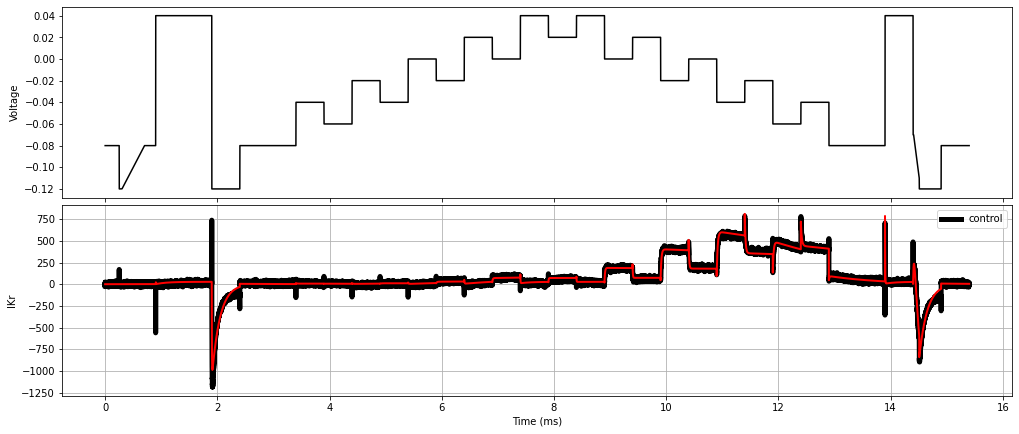

std : 11.53081979933415


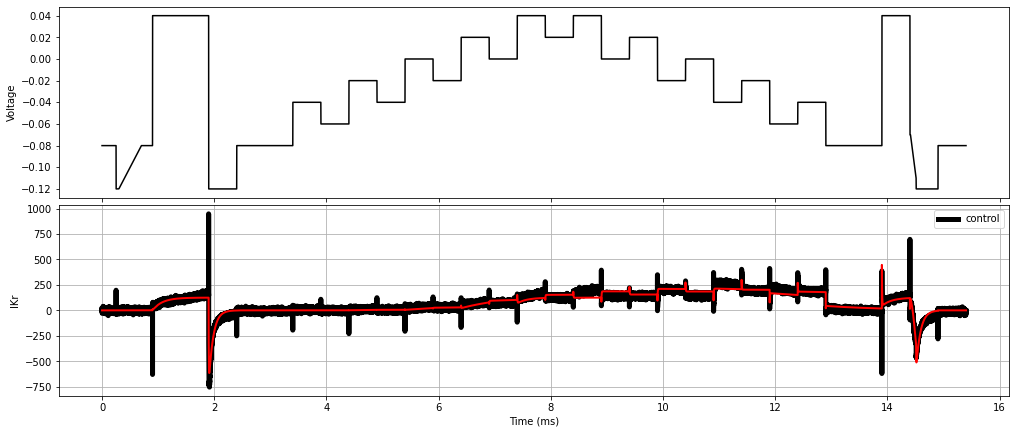

std : 10.914820717110837


In [26]:
show_range = 2

for x, y in zip(xs[:show_range], ys[:show_range]):    
    model_params = {                    
        'ikr.g' : y[0],  # random.uniform(parameter_ranges[0][0], parameter_ranges[0][1]),
        'ikr.p1' : y[1],
        'ikr.p2' : y[2],
        'ikr.p3' : y[3],
        'ikr.p4' : y[4],
        'ikr.p5' : y[5],
        'ikr.p6' : y[6],
        'ikr.p7' : y[7],
        'ikr.p8' : y[8],                
    } 
    sim.set_simulation_params(model_params)                

    sim.pre_simulate(100, sim_type=1)
    # d = sim.simulate( gen_params['end_time'], log_times=gen_params['t_eval'], extra_log=gen_params['log_li'])                           
    d = sim.simulate( gen_params['end_time'], log_times=None, extra_log=gen_params['log_li'])                           

    sim_result= {}
    sim_result["Time"] = d['engine.time']
    sim_result["IKr"] = d['ikr.IKr'] # + np.random.normal(0, std_avg , d['ikr.IKr'].shape) # add noise
    sim_result["open"] = d['ikr.open']
    sim_result["active"] = d['ikr.open']
    sim_result["params"] = y
    
    
    fig, ax = plt.subplots(2,1, figsize=(15,6))    
    # fig.suptitle(sim.name, fontsize=14)
    # if name!='Time Start' and name!='Time End' and name!='Time Mid':
    # ax.set_title('Simulation %d'%(simulationNo))    
    # ax.set_ylim(ylim[0], ylim[1])
    
    ax[0].set_xlabel('Time (ms)')       
    ax[0].set_ylabel(f'Voltage')      
    ax[0].plot( times, VC_protocol.get_voltage_clamp_protocol(times), label='VC', color='k')
    
    ax[1].set_xlabel('Time (ms)')       
    ax[1].set_ylabel(f'IKr')      
    ax[1].plot( times, x, label='control', color='k', linewidth=5)         
    ax[1].plot( sim_result['Time'], sim_result['IKr'], color='r', linewidth=2)
    ax[1].legend()
    ax[1].grid()
    
    # ax[0].set_xlim(13.8, 14)
    # ax[1].set_xlim(13.8, 14)
    # ax[-1].set_ylim(-5, 5)
    plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.95, wspace=0.5, hspace=0.04)
    plt.show()
    # fig.savefig(os.path.join('Results', "C.jpg"), dpi=100)
    
    print( f"std : {np.std(x[:check_range])}" )
    print("="*200)